In [1]:
%matplotlib inline

from __future__ import division, print_function

import glob as glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import optimize

sns.set_style('white')

### Set parameters

In [2]:
N_samples = 10000
threshold = .5 #threshold to pass to reach "success"
REWARD = 1


### Free parameters to fit (later on)

In [3]:
#COST = 0.5
#B=6
#A=60 
#u_skill = .625 #mean of beta
#tao_skill = 20 #variance of beta

### Functions

In [9]:
def prob_reward(e,diff,skill, A, B):
    """Return the probability of getting the reward
    
    Parameters
    ----------
    e : numeric or array-like
        Description of parameter 'effort'
    diff: numeric or array-like 
        Description of parameter 'difficulty"
    skill: numeric or array-like 
        Description of parameter 'skill"
    A: numeric parameter that moves
        Function left and right
    B: numeric parameter than changes
        Sharpness of function
    
    Returns
    -------
    Numeric or array-like value of probabilty of getting a reward between 0-1
    ...
    """
    return 1/(1 + A * np.exp(-(e * skill / diff) * B)) ##plot for different As (moves function around) and Bs (changes sharpness)


def get_effort_multidim(cost, diff, skill, A, B, reward=1):
    """Function that returns optimal effort given different skills and difficulties.
    Runs utility function of the form utility = reward* probability of getting
    reward - cost* effort 
    Cost is set but scales with effort
    Reward is set but scales with probability of getting it
    This function finds the argmax value of utility and returns that as the 
    'optimal' effort that should be exerted given some difficuly, skill, cost, and reward.
    

    Parameters
    ----------
    cost : numeric description of 'cost'
    diff: numeric or array-like 
        Description of parameter 'difficulty'
    skill: numeric or array-like 
        Description of parameter 'skill'
    A: numeric parameter that moves
        Function left and right
    B: numeric parameter than changes
        Sharpness of function
    reward: numeric set to 1 for 'reward'

    Returns
    -------
    Ndarray of effort with same shape as `diff` and `skill`.
    """
    es = np.linspace(0, 1, 100)
    es_rank2 = es[np.newaxis, ...]
    
    try:
        diff = diff[..., np.newaxis]
    except TypeError:
        pass
    try:
        skill = skill[..., np.newaxis]
    except TypeError:
        pass
    
    prob = prob_reward(e=es_rank2, diff=diff, skill=skill, A=A, B=B)
    utilities = reward * prob - cost * es_rank2
    return es[utilities.argmax(-1)]



def create_priors_opt(n_samples, tao_skill, u_skill, u_diff, tao_diff, cost, A, B, reward=1, 
                      effort_threshold=0.5):
    """Model for creating priors of DIFFICULTY at different effort and success thresholds
    
    Parameters
    ----------
    n_samples : int of number of samples
        You want to run
    tao_skill: numeric, variance of skill beta function
    u_skill: numeric, mean of skill beta function
    cost : numeric of cost number
    A : numeric scaling variable for "prob_reward"
        That moves function left or right
    B : numeric scaling variable for "prob_reward" 
        That sharpens peak of function
    diff: numeric or array-like parameter
        of difficulty
    reward : numeric value of reward
    effort_threshold: threshold that determines boundry
        Between high and low effort
    
    Returns
    -------
    Ndarray of skill, success trials, and high effort trials
    """
    # Skill and diff are beta distributions.
    skills = np.random.beta(
        tao_skill * u_skill, (1 - u_skill) * tao_skill, size=n_samples,
    )
    
    u_diff = 0.5
    tao_diff=1
    
    diffs = np.random.beta(tao_diff*u_diff , (1-u_diff)*tao_diff, size=n_samples)
    
    efforts = get_effort_multidim(
        cost=cost, skill=skills, diff=diffs, A=A, B=B,
    )

    high_effort = efforts > effort_threshold
    success = prob_reward(efforts, diffs, skills, A, B) > np.random.random(n_samples)

    return skills, diffs, success, high_effort

def your_eff_know_skill_opt(n_samples, cost, diff, skill, A, B,reward=1):
    """Model for planning.

    Parameters
    ----------
    n_samples : int
    cost : numeric
    diff : array-like
    skill : numeric
    A : numeric
    B : numeric
    reward : numeric
    
    Returns
    -------
    Ndarray of effort.
    """
    rand_diffs = np.random.choice(diff, size=n_samples)
    return get_effort_multidim(
        cost=cost, diff=rand_diffs, skill=skill, A=A, B=B, reward=reward
    )



def rmse(predictions, targets):
    """function for comparing model predictions to target data

    Parameters
    ----------
    predictions: array of model predictions
    targets: array of target data (human data)

    Returns
    -------
    numeric value of root mean squared fit of values
    """
    return np.sqrt(((predictions - targets) ** 2).mean())

## Plot Utility Functions

#### Variables I set --> free parameters

In [10]:
REWARD = 1
COST = .5
skilled = .8
unskilled = .2
hard = .8
easy = .2
A = 2
B = 9

#### First let's plot prob(reward) for varying levels of skill, effort, and difficulty

Text(0.5,1,'Hard')

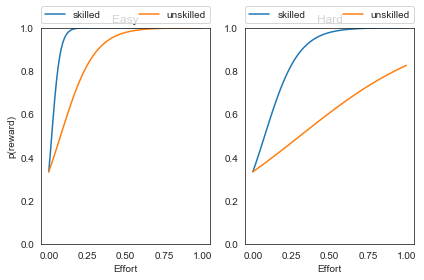

In [11]:
es=np.linspace(0,1,100)
p0 = [prob_reward(e,easy,unskilled, A, B) for e in es]
p1 = [prob_reward(e,easy,skilled,A, B) for e in es]

plt.subplot(1,2,1)
plt.plot(es, p1, label = "skilled")
plt.plot(es,p0, label = "unskilled")
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Effort') ; plt.ylabel('p(reward)'); plt.title('Easy')

p0 = [prob_reward(e,hard,unskilled,A, B) for e in es]
p1 = [prob_reward(e,hard,skilled,A, B) for e in es]
plt.subplot(1,2,2)
plt.plot(es, p1, label = "skilled")
plt.plot(es,p0,label = "unskilled")
plt.tight_layout()
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Effort') ;  plt.title('Hard')

Question for max - why does this function not start at prob reward = 0 when effort is 0??

#### Function that is similar to "get_effort_multidem" but simpiler for plotting purposes
* runs a utility function that finds the peak utility of "effort" for each combination of difficulty and skill

In [12]:
def get_effort(reward, cost, diff, skill):
    Us=list()
    es = np.linspace(0, 1, 100) 
    for i in es:
        U=reward*prob_reward(i, diff, skill, A, B)-cost*i #utility function
        Us.append(U)
    return es[np.argmax(Us)], Us, es  #return argmax of utility, and utilities 

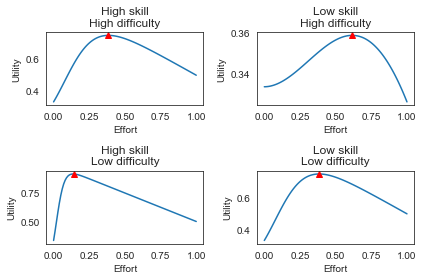

In [13]:
plt.subplot(2,2,1)
effort,Us,es=get_effort(REWARD,COST,hard,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('High skill\nHigh difficulty')
plt.tight_layout()

plt.subplot(2,2,2)
effort,Us,es=get_effort(REWARD,COST,hard,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('Low skill\nHigh difficulty')
plt.tight_layout()

plt.subplot(2,2,3)
effort,Us,es=get_effort(REWARD,COST,easy,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('High skill\nLow difficulty')
plt.tight_layout()

plt.subplot(2,2,4)
effort,Us,es=get_effort(REWARD,COST,easy,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')
plt.title('Low skill\nLow difficulty')
plt.tight_layout()

#### These plots capture our intutions about what should happen in each situation
* High skill, high difficulty: you should have to try pretty hard
* Low skill, high difficulty: you should have to try REALLY hard
* High skill, low difficulty: you shouldn't have to try very hard
* Low skill, low difficulty: you should have to try pretty hard

All things being equal, the rank of trying here from most to least is:
    1. low skill + high diff
    2. high skill + high diff
    3. low skill + low diff
    4. high skill + low diff

### Function that takes in free parameters and spits out model predictions

In [14]:
def run_model_opt(cost, A, B, u_skill, tao_skill, u_diff = 0.5, tao_diff = 1,n_samples=10000):
    """function that takes in free parameters and returns model predictions (predicted effort)
    by condition (here split by high/low effort and success/failure). In other words,
    given some set of another person's effort, outcome and skill, what is the expected difficulty 
    of the task? And how do you use this expected difficulty to calibrate your own effort, condisering 
    your own skill. 

    Parameters
    ----------
    cost : numeric of cost number
    A : numeric scaling variable for "prob_reward"
        That moves function left or right
    B : numeric scaling variable for "prob_reward" 
        That sharpens peak of function
    tao_skill: numeric, variance of skill beta function
    u_skill: numeric, mean of skill beta function
    tao_diff: numeric, variance of diff beta function
    u_diff: numeric, mean of diff beta function


    Returns
    -------
    means of effort calculated for each n_sample calculation done at a given difficulty
    and success level
    """
    
    np.random.seed(0)
    REWARD=1
    skill = .5
    
    
    skills, diffs, success, high_effort= create_priors_opt(
        n_samples =n_samples, tao_skill=tao_skill, u_skill=u_skill, cost=cost, A=A, B=B,
        u_diff=u_diff, tao_diff=tao_diff
    )

    effort_high_success = your_eff_know_skill_opt(n_samples, cost, diffs[success & high_effort],skill, A,B) 
    effort_low_success = your_eff_know_skill_opt(n_samples,  cost, diffs[success & (~high_effort)],skill,A,B) 
    effort_high_fail = your_eff_know_skill_opt(n_samples,  cost, diffs[(~success) & high_effort],skill,A,B) 
    effort_low_fail = your_eff_know_skill_opt(n_samples,  cost, diffs[(~success) & (~high_effort)],skill,A,B) 
    effort_baseline = your_eff_know_skill_opt(n_samples,  cost, np.random.beta(tao_diff*u_diff, (1-u_diff)*tao_diff, size=n_samples),skills,A,B)


    model_means = np.stack(
        (effort_high_success, effort_low_success, effort_high_fail, 
         effort_low_fail, effort_baseline),
    ).mean(-1)
    
    return model_means


In [15]:
output= run_model_opt(cost = .6, A = 2, B = 9, u_skill = .5, tao_skill = 1,  n_samples=10000) #play with parameters
output


array([0.41143939, 0.28093434, 0.4162798 , 0.39954545, 0.21211313])

## Create priors and model predictions where the modeler is VERY skilled

In [16]:
def create_priors_highS(n_samples,  cost, A, B, u_diff = 0.5, tao_diff=1,  reward=1, 
                      threshold=0.5):
    """Model for creating priors of skill at different effort and success thresholds
    
    Parameters
    ----------
    n_samples : int of number of samples
        You want to run

    Returns
    -------
    Ndarray of skill, success trials, and high effort trials
    """
    # Skill and diff are beta distributions.
    high_skill = .8
    
    diffs = np.random.beta(tao_diff*u_diff , (1-u_diff)*tao_diff, size=n_samples)
    
    efforts = get_effort_multidim(
        cost=cost, skill=high_skill, diff=diffs, A=A, B=B,
    )
    
    high_effort = efforts > threshold
    success = prob_reward(efforts, diffs,high_skill, A, B) > np.random.random(n_samples)
    
    
    return success, high_effort, diffs

def run_model_highS(cost, A, B,  u_diff = 0.5, tao_diff = 1, n_samples=10000):
    """function that takes in free parameters and returns model predictions (predicted effort)
    when skill is high only 
    Parameters
    ----------
    """
    
    np.random.seed(0)
    REWARD=1
    skill = .2 #lower skill than modeler
    
    success, high_effort, diffs= create_priors_highS(
        n_samples =n_samples, cost=cost, A=A, B=B,u_diff=u_diff, tao_diff=tao_diff
    )
    

    effort_high_success = your_eff_know_skill_opt(n_samples, cost, diffs[success & high_effort],skill, A,B) 
    effort_low_success = your_eff_know_skill_opt(n_samples,  cost, diffs[success & (~high_effort)],skill,A,B) 
    effort_high_fail = your_eff_know_skill_opt(n_samples,  cost, diffs[(~success) & high_effort],skill,A,B) 
    effort_low_fail = your_eff_know_skill_opt(n_samples,  cost, diffs[(~success) & (~high_effort)],skill,A,B) 
    effort_baseline = your_eff_know_skill_opt(n_samples,  cost, np.random.beta(tao_diff*u_diff, (1-u_diff)*tao_diff, size=n_samples),skill,A,B)


    model_means = np.stack(
        (effort_high_success, effort_low_success, effort_high_fail, 
         effort_low_fail, effort_baseline),
    ).mean(-1)
    

    return model_means,effort_high_success ,effort_low_success,effort_high_fail ,effort_low_fail, effort_baseline 



In [17]:
model_means,effort_high_success ,effort_low_success,effort_high_fail ,effort_low_fail, effort_baseline = run_model_highS(cost = .3, A = 2, B = 9,  n_samples=10000) #play with parameters
model_means

array([1.        , 0.60112828, 1.        , 0.89258788, 0.67122828])

## Plot out predicted effort by condition when the modeler is VERY skilled

In [18]:
d = {'High Effort Success':  effort_high_success, 'Low Effort Success': effort_low_success, 'High Effort Failure': effort_high_fail, 'Low Effort Failure': effort_low_fail,"Baseline":effort_baseline}
eff_df = pd.DataFrame(data=d)
eff_df.head()

,Baseline,High Effort Failure,High Effort Success,Low Effort Failure,Low Effort Success
0,0.272727,1.0,1.0,1.000000,1.000000
1,1.000000,1.0,1.0,0.989899,1.000000
2,0.838384,1.0,1.0,1.000000,0.262626
3,0.545455,1.0,1.0,0.909091,1.000000
4,1.000000,1.0,1.0,1.000000,0.909091


In [29]:
eff_melt=pd.melt(eff_df, value_vars=['High Effort Success','Low Effort Success','High Effort Failure', 'Low Effort Failure',])
eff_melt.head()

,variable,value
0,High Effort Success,1.0
1,High Effort Success,1.0
2,High Effort Success,1.0
3,High Effort Success,1.0
4,High Effort Success,1.0


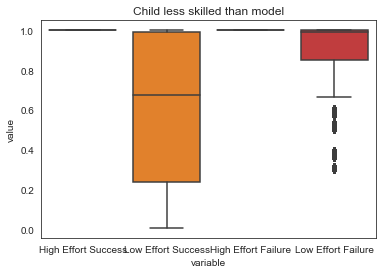

In [30]:
ax=sns.boxplot(x="variable", y="value", data=eff_melt).set_title("Child less skilled than model")


Interpretation: if the child is less skilled than the modeler, they should:
* try max hard when the model tries hard and succeeds
* should try medium hard when the model doesn't have to try hard and succeed
* try max hard when the model tries hard and fails --> QUESTION, does this seem right?
* try really hard when the model puts in little effort and fails --> are we even running this condition? What does this mean?

## Create priors and model predictions where the modeler is NOT skilled

In [37]:
def create_priors_LowS(n_samples,  cost, A, B, u_diff = 0.5, tao_diff=1,  reward=1, 
                      threshold=0.5):
    """Model for creating priors of skill at different effort and success thresholds
    
    Parameters
    ----------
    n_samples : int of number of samples
        You want to run

    Returns
    -------
    Ndarray of skill, success trials, and high effort trials
    """
    # Skill and diff are beta distributions.
    low_skill = .2
    
    diffs = np.random.beta(tao_diff*u_diff , (1-u_diff)*tao_diff, size=n_samples)
    
    efforts = get_effort_multidim(
        cost=cost, skill=low_skill, diff=diffs, A=A, B=B,
    )
    
    high_effort = efforts > threshold
    success = prob_reward(efforts, diffs,low_skill, A, B) > np.random.random(n_samples)
    
    
    return success, high_effort, diffs

def run_model_LowS(cost, A, B,  u_diff = 0.5, tao_diff = 1, n_samples=10000):
    """function that takes in free parameters and returns model predictions (predicted effort)
    when skill is high only 
    Parameters
    ----------
    """
    
    np.random.seed(0)
    REWARD=1
    skill = .8 #higher skill than modeler
    
    success, high_effort, diffs= create_priors_LowS(
        n_samples =n_samples, cost=cost, A=A, B=B,u_diff=u_diff, tao_diff=tao_diff
    )
    

    effort_high_success = your_eff_know_skill_opt(n_samples, cost, diffs[success & high_effort],skill, A,B) 
    effort_low_success = your_eff_know_skill_opt(n_samples,  cost, diffs[success & (~high_effort)],skill,A,B) 
    effort_high_fail = your_eff_know_skill_opt(n_samples,  cost, diffs[(~success) & high_effort],skill,A,B) 
    effort_low_fail = your_eff_know_skill_opt(n_samples,  cost, diffs[(~success) & (~high_effort)],skill,A,B) 
    effort_baseline = your_eff_know_skill_opt(n_samples,  cost, np.random.beta(tao_diff*u_diff, (1-u_diff)*tao_diff, size=n_samples),skill,A,B)


    model_means = np.stack(
        (effort_high_success, effort_low_success, effort_high_fail, 
         effort_low_fail, effort_baseline),
    ).mean(-1)
    

    return model_means,effort_high_success ,effort_low_success,effort_high_fail ,effort_low_fail, effort_baseline 


In [38]:
model_means,effort_high_success ,effort_low_success,effort_high_fail ,effort_low_fail, effort_baseline = run_model_LowS(cost = .3, A = 2, B = 9,  n_samples=10000) #play with parameters
model_means

array([0.39141616, 0.06785859, 0.44678586, 0.11940303, 0.28918283])

## Plot out predicted effort by condition when the modeler is NOT skilled

In [39]:
d = {'High Effort Success':  effort_high_success, 'Low Effort Success': effort_low_success, 'High Effort Failure': effort_high_fail, 'Low Effort Failure': effort_low_fail,"Baseline":effort_baseline}
eff_df = pd.DataFrame(data=d)
eff_df.head()

,Baseline,High Effort Failure,High Effort Success,Low Effort Failure,Low Effort Success
0,0.525253,0.525253,0.505051,0.141414,0.060606
1,0.414141,0.525253,0.464646,0.101010,0.111111
2,0.030303,0.515152,0.494949,0.151515,0.010101
3,0.262626,0.515152,0.444444,0.161616,0.090909
4,0.525253,0.494949,0.363636,0.030303,0.010101


In [40]:
eff_melt=pd.melt(eff_df, value_vars=['High Effort Success','Low Effort Success','High Effort Failure', 'Low Effort Failure',])
eff_melt.head()

,variable,value
0,High Effort Success,0.505051
1,High Effort Success,0.464646
2,High Effort Success,0.494949
3,High Effort Success,0.444444
4,High Effort Success,0.363636


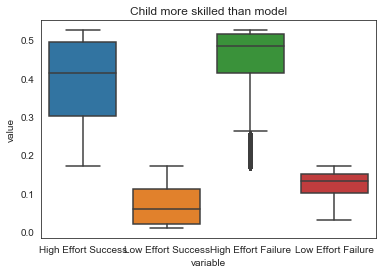

In [41]:
ax=sns.boxplot(x="variable", y="value", data=eff_melt).set_title("Child more skilled than model")

Interpretation: if the child is more skilled than the modeler, they should:

* try very hard when the model tries hard and succeeds
* not try very hard when the model doesn't have to try hard and succeeds
* try very hard when the model tries hard and fails - harder then the effort + success model
* try medium hard when the model doesn't try and fails